In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sp500csv = pd.read_csv("data_Q2.csv", sep=";")

sp500csv["Date"] = pd.to_datetime(sp500csv["Date"])

vti = sp500csv[sp500csv["ticker"] == "VTI"].copy()
tlt = sp500csv[sp500csv["ticker"] == "TLT"].copy()

vti = vti.sort_values(by="Date")
tlt = tlt.sort_values(by="Date")


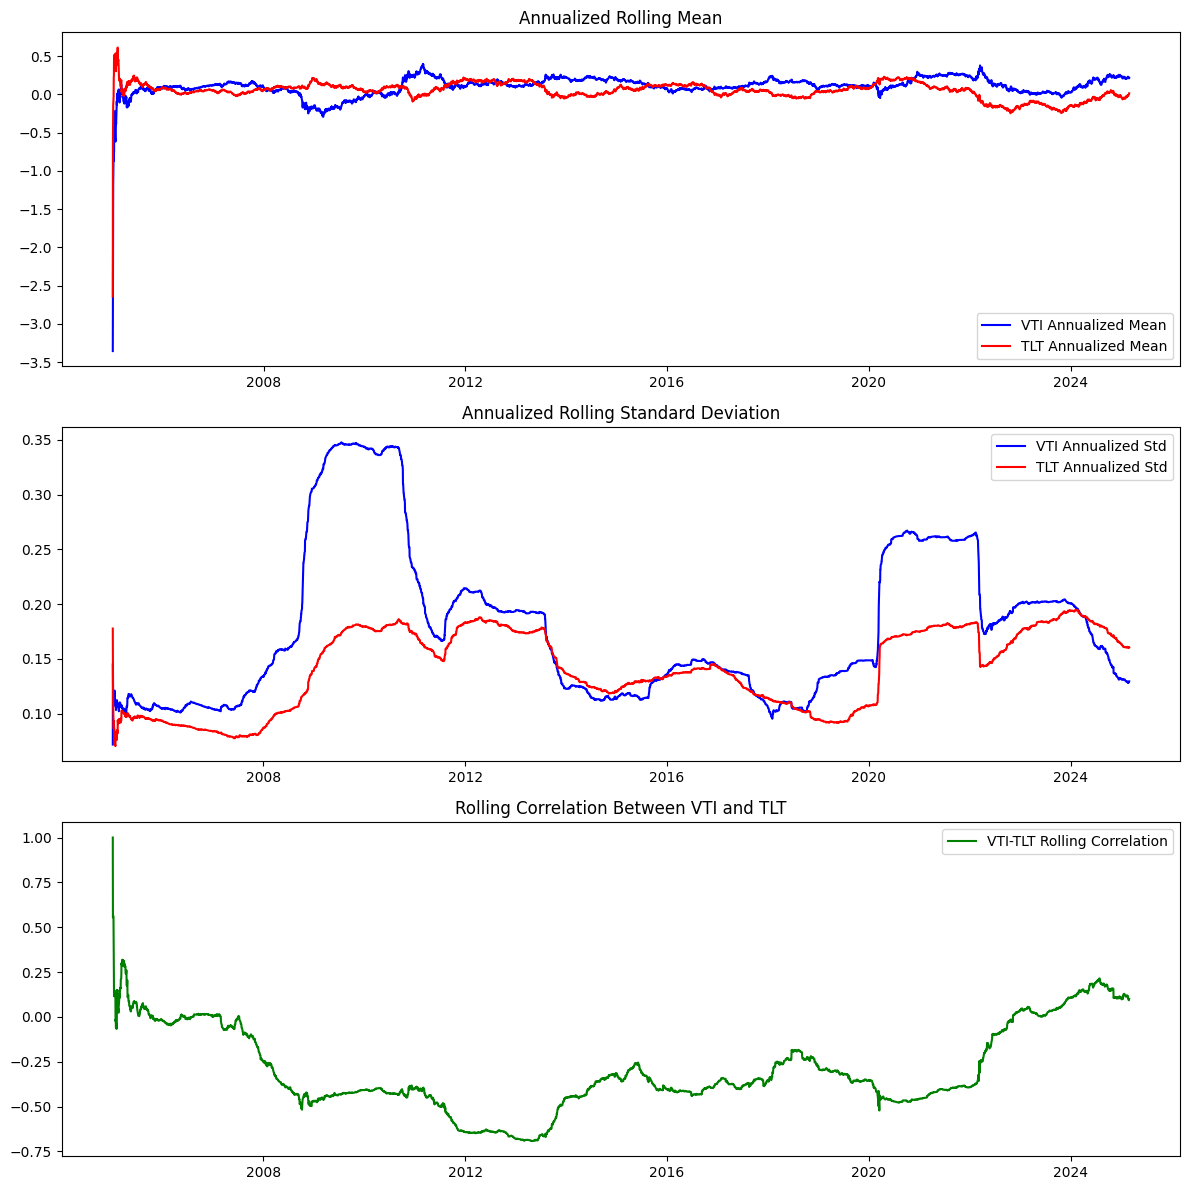

        Date  Adj Close      Close       High        Low       Open  Volume  \
0 2005-01-03  40.582745  58.599998  59.424999  58.450001  59.400002  525000   
1 2005-01-04  40.042564  57.820000  58.750000  57.639999  58.750000  244200   
2 2005-01-05  39.765560  57.419998  57.974998  57.419998  57.875000  380800   
3 2005-01-06  39.955990  57.695000  57.895000  57.430000  57.549999  201800   
4 2005-01-07  39.827881  57.509998  57.825001  57.355000  57.799999  271200   

  ticker    Return  Rolling_Mean  Rolling_Std  Annualized_Mean  Annualized_Std  
0    VTI       NaN           NaN          NaN              NaN             NaN  
1    VTI -0.013311     -0.013311          NaN        -3.354268             NaN  
2    VTI -0.006918     -0.010114     0.004520        -2.548770        0.071759  
3    VTI  0.004789     -0.005147     0.009179        -1.296920        0.145709  
4    VTI -0.003206     -0.004661     0.007557        -1.174684        0.119963  
           Date  Adj Close      Close  

In [3]:

vti.loc[:, "Return"] = vti["Adj Close"].pct_change()
tlt.loc[:, "Return"] = tlt["Adj Close"].pct_change()

vti.loc[:, "Rolling_Mean"] = vti["Return"].rolling(window=500, min_periods=1).mean()
vti.loc[:, "Rolling_Std"] = vti["Return"].rolling(window=500, min_periods=1).std()

tlt.loc[:, "Rolling_Mean"] = tlt["Return"].rolling(window=500, min_periods=1).mean()
tlt.loc[:, "Rolling_Std"] = tlt["Return"].rolling(window=500, min_periods=1).std()

vti.loc[:, "Annualized_Mean"] = vti["Rolling_Mean"] * 252
vti.loc[:, "Annualized_Std"] = vti["Rolling_Std"] * np.sqrt(252)

tlt.loc[:, "Annualized_Mean"] = tlt["Rolling_Mean"] * 252
tlt.loc[:, "Annualized_Std"] = tlt["Rolling_Std"] * np.sqrt(252)

returns_df = pd.merge(vti[["Date", "Return", "Rolling_Std"]],
                      tlt[["Date", "Return", "Rolling_Std"]],
                      on="Date", suffixes=("_VTI", "_TLT"))

returns_df.loc[:, "Rolling_Corr"] = returns_df["Return_VTI"].rolling(window=500, min_periods=1).corr(returns_df["Return_TLT"])

# print(vti["Annualized_Mean"].to_latex())

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

axes[0].plot(vti["Date"], vti["Annualized_Mean"], label="VTI Annualized Mean", color="blue")
axes[0].plot(tlt["Date"], tlt["Annualized_Mean"], label="TLT Annualized Mean", color="red")
axes[0].set_title("Annualized Rolling Mean")
axes[0].legend()

axes[1].plot(vti["Date"], vti["Annualized_Std"], label="VTI Annualized Std", color="blue")
axes[1].plot(tlt["Date"], tlt["Annualized_Std"], label="TLT Annualized Std", color="red")
axes[1].set_title("Annualized Rolling Standard Deviation")
axes[1].legend()

axes[2].plot(returns_df["Date"], returns_df["Rolling_Corr"], label="VTI-TLT Rolling Correlation", color="green")
axes[2].set_title("Rolling Correlation Between VTI and TLT")
axes[2].legend()

plt.tight_layout()
plt.show()
print(vti.head())
print(tlt.head())
print(returns_df.head())


/tmp/ipykernel_844/323371571.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vti_monthly = vti.resample("M", on="Date").last()
/tmp/ipykernel_844/323371571.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tlt_monthly = tlt.resample("M", on="Date").last()


Strategy Returns (Head of the DataFrame):
        Date  Parity_Return  Tangency_Return  Min_Variance_Return  \
0 2005-01-03            NaN              NaN                  NaN   
1 2005-01-04      -0.011895        -0.011959            -0.011619   
2 2005-01-05      -0.000783        -0.001058             0.000414   
3 2005-01-06       0.002734         0.002826             0.002333   
4 2005-01-07      -0.000471        -0.000593             0.000063   

   60_40_Return  
0           NaN  
1     -0.012178  
2     -0.002010  
3      0.003145  
4     -0.001018  


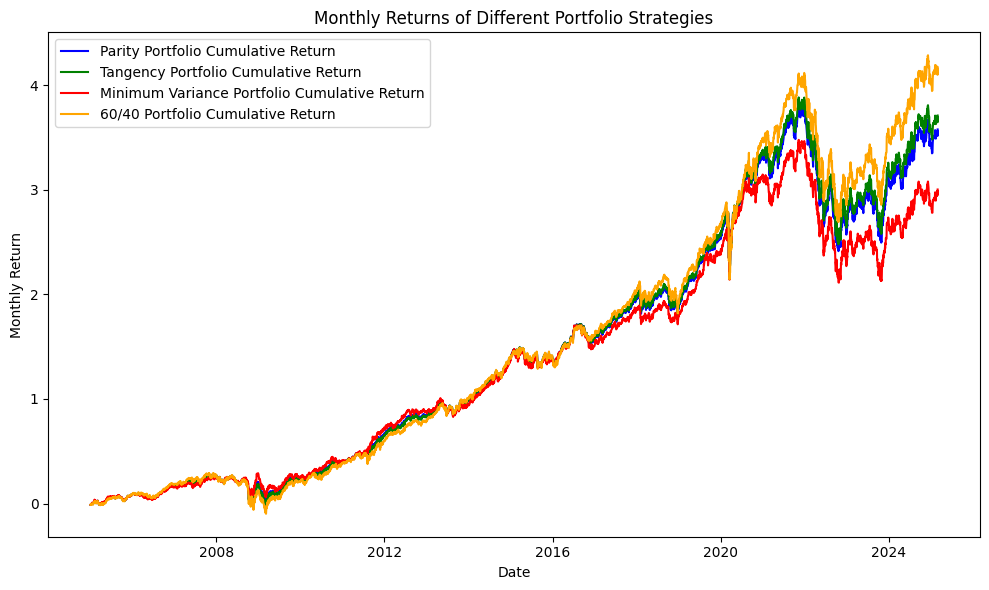

In [ ]:
vti_monthly = vti.resample("M", on="Date").last()
tlt_monthly = tlt.resample("M", on="Date").last()

vti_monthly.loc[:, "Monthly_Return"] = vti_monthly["Adj Close"].pct_change()
tlt_monthly.loc[:, "Monthly_Return"] = tlt_monthly["Adj Close"].pct_change()

returns_df["Parity_Return"] = (returns_df["Return_VTI"] * 0.5 + returns_df["Return_TLT"] * 0.5)

cov_matrix = returns_df[["Return_VTI", "Return_TLT"]].cov()

mean_returns = returns_df[["Return_VTI", "Return_TLT"]].mean()

sharpe_ratio = np.linalg.inv(cov_matrix).dot(mean_returns)  # Tangency
tangency_weight_vti = sharpe_ratio[0] / (sharpe_ratio[0] + sharpe_ratio[1])  # VTI
tangency_weight_tlt = 1 - tangency_weight_vti  # TLT

returns_df["Tangency_Return"] = (returns_df["Return_VTI"] * tangency_weight_vti + returns_df["Return_TLT"] * tangency_weight_tlt)

inv_cov_matrix = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

min_var_weights = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)

min_var_weight_vti = min_var_weights[0]
min_var_weight_tlt = 1 - min_var_weight_vti

returns_df["Min_Variance_Return"] = (returns_df["Return_VTI"] * min_var_weight_vti + returns_df["Return_TLT"] * min_var_weight_tlt)

returns_df["60_40_Return"] = (returns_df["Return_VTI"] * 0.6 + returns_df["Return_TLT"] * 0.4)

print("Strategy Returns (Head of the DataFrame):")
print(returns_df[["Date", "Parity_Return", "Tangency_Return", "Min_Variance_Return", "60_40_Return"]].head())

returns_df["Cumulative_Parity_Return"] = (1 + returns_df["Parity_Return"]).cumprod() - 1
returns_df["Cumulative_Tangency_Return"] = (1 + returns_df["Tangency_Return"]).cumprod() - 1
returns_df["Cumulative_Min_Variance_Return"] = (1 + returns_df["Min_Variance_Return"]).cumprod() - 1
returns_df["Cumulative_60_40_Return"] = (1 + returns_df["60_40_Return"]).cumprod() - 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns_df["Date"], returns_df["Cumulative_Parity_Return"], label="Parity Portfolio Cumulative Return", color="blue")
ax.plot(returns_df["Date"], returns_df["Cumulative_Tangency_Return"], label="Tangency Portfolio Cumulative Return", color="green")
ax.plot(returns_df["Date"], returns_df["Cumulative_Min_Variance_Return"], label="Minimum Variance Portfolio Cumulative Return", color="red")
ax.plot(returns_df["Date"], returns_df["Cumulative_60_40_Return"], label="60/40 Portfolio Cumulative Return", color="orange")

ax.set_title("Monthly Returns of Different Portfolio Strategies")
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Return")
ax.legend()

plt.tight_layout()
plt.show()


                   Parity  Tangency  Min_Variance     60_40
Annualized Mean  0.080685  0.082297      0.073655  0.087893
Annualized Std   0.100750  0.102589      0.097052  0.111440
Sharpe Ratio     0.800846  0.802208      0.758916  0.788703


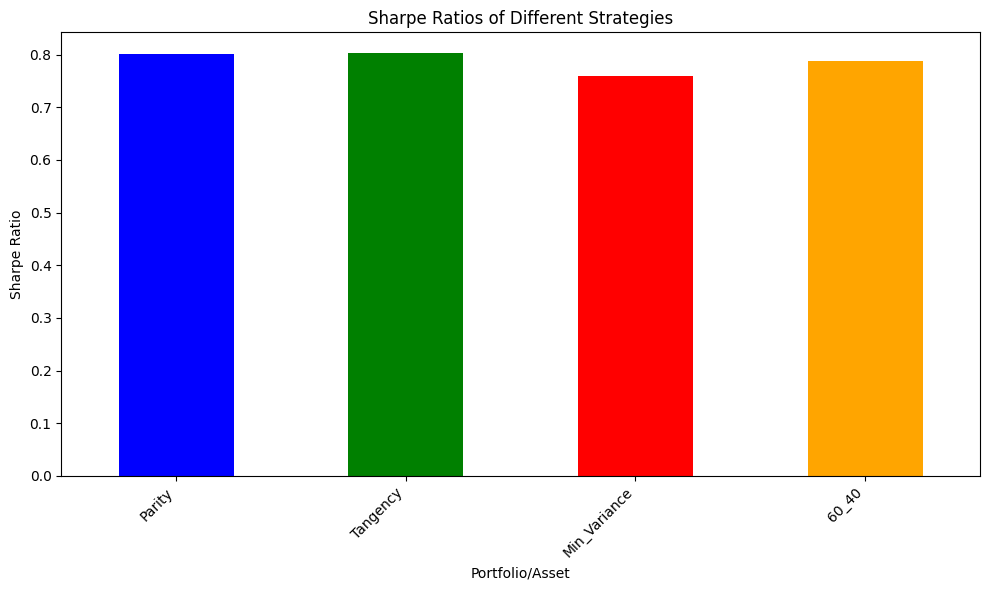

In [5]:
returns_train = returns_df[returns_df["Date"] >= "2007-01-01"]

def annualized_stats(df, return_column):
    annualized_mean = df[return_column].mean() * 252
    annualized_std = df[return_column].std() * np.sqrt(252)
    sharpe_ratio = annualized_mean / annualized_std
    return annualized_mean, annualized_std, sharpe_ratio

annualized_stats_dict = {
    "Parity": annualized_stats(returns_df, "Parity_Return"),
    "Tangency": annualized_stats(returns_df, "Tangency_Return"),
    "Min_Variance": annualized_stats(returns_df, "Min_Variance_Return"),
    "60_40": annualized_stats(returns_df, "60_40_Return"),
}

annualized_df = pd.DataFrame(annualized_stats_dict, index=["Annualized Mean", "Annualized Std", "Sharpe Ratio"])

print(annualized_df)

fig, ax = plt.subplots(figsize=(10, 6))
annualized_df.loc["Sharpe Ratio"].plot(kind="bar", ax=ax, color=["blue", "green", "red", "orange", "purple", "brown"])
ax.set_title("Sharpe Ratios of Different Strategies")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Portfolio/Asset")
ax.set_xticklabels(annualized_df.columns, rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
vti_price_end_feb = vti[vti["Date"] == "2025-02-28"]["Adj Close"].iloc[0]
tlt_price_end_feb = tlt[tlt["Date"] == "2025-02-28"]["Adj Close"].iloc[0]

portfolio_value = 100000
allocation_vti = portfolio_value * 0.5
allocation_tlt = portfolio_value * 0.5

shares_vti = int(allocation_vti // vti_price_end_feb)
shares_tlt = int(allocation_tlt // tlt_price_end_feb)

print(f"Shares of VTI to hold: {shares_vti}")
print(f"Shares of TLT to hold: {shares_tlt}")

total_invested_vti = shares_vti * vti_price_end_feb
total_invested_tlt = shares_tlt * tlt_price_end_feb
print(f"Total invested in VTI: {total_invested_vti}")
print(f"Total invested in TLT: {total_invested_tlt}")
print(f"Total invested: {total_invested_vti + total_invested_tlt}")

Shares of VTI to hold: 170
Shares of TLT to hold: 542
Total invested in VTI: 49803.19854736328
Total invested in TLT: 49939.87966918945
Total invested: 99743.07821655273
